# **関数読み込み**

In [1]:
!sudo apt-get install -q -y timidity libsndfile1
!pip install pydub numba==0.48 librosa music21
!pip install SpeechRecognition
!pip install pydub

import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
import librosa
from librosa import display as librosadisplay
import math
import statistics
import sys
from IPython.display import Audio, Javascript
from scipy.io import wavfile
from base64 import b64decode
import music21
from pydub import AudioSegment

import wave
import struct
import IPython.display

import os
import glob
import speech_recognition
import pydub

Reading package lists...
Building dependency tree...
Reading state information...
libsndfile1 is already the newest version (1.0.28-4ubuntu0.18.04.2).
The following additional packages will be installed:
  freepats libaudio2 timidity-daemon
Suggested packages:
  nas fluid-soundfont-gm fluid-soundfont-gs pmidi
The following NEW packages will be installed:
  freepats libaudio2 timidity timidity-daemon
0 upgraded, 4 newly installed, 0 to remove and 39 not upgraded.
Need to get 29.6 MB of archives.
After this operation, 35.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 freepats all 20060219-1 [29.0 MB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libaudio2 amd64 1.9.4-6 [50.3 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 timidity amd64 2.13.2-41 [585 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/universe amd64 timidity-daemon all 2.13.2-41 [5,984 B]
Fetched 29.6 MB in 3s (10.5 MB/s)
debconf: unable

# **音声録音**

In [2]:
#@title 録音時間（秒）の指定
speech_time =  6#@param {type:"integer"}

RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec=5):
  try:
    from google.colab import output
  except ImportError:
    print('No possible to import output from google.colab')
    return ''
  else:
    print('Recording')
    display(Javascript(RECORD))
    s = output.eval_js('record(%d)' % (sec*1000))
    fname = 'recorded_audio.wav'
    print('Saving to', fname)
    b = b64decode(s.split(',')[1])
    with open(fname, 'wb') as f:
      f.write(b)
    return fname

uploaded_file_name = record(speech_time+1)

print("Saved")

Recording


<IPython.core.display.Javascript object>

Saving to recorded_audio.wav
Saved


# **音声データ表示/FFT**

音声波形の表示
Channel:  1
Sample width:  4
Frame Rate:  16000
Frame num:  111360
Params:  _wave_params(nchannels=1, sampwidth=4, framerate=16000, nframes=111360, comptype='NONE', compname='not compressed')
Total time:  6.96


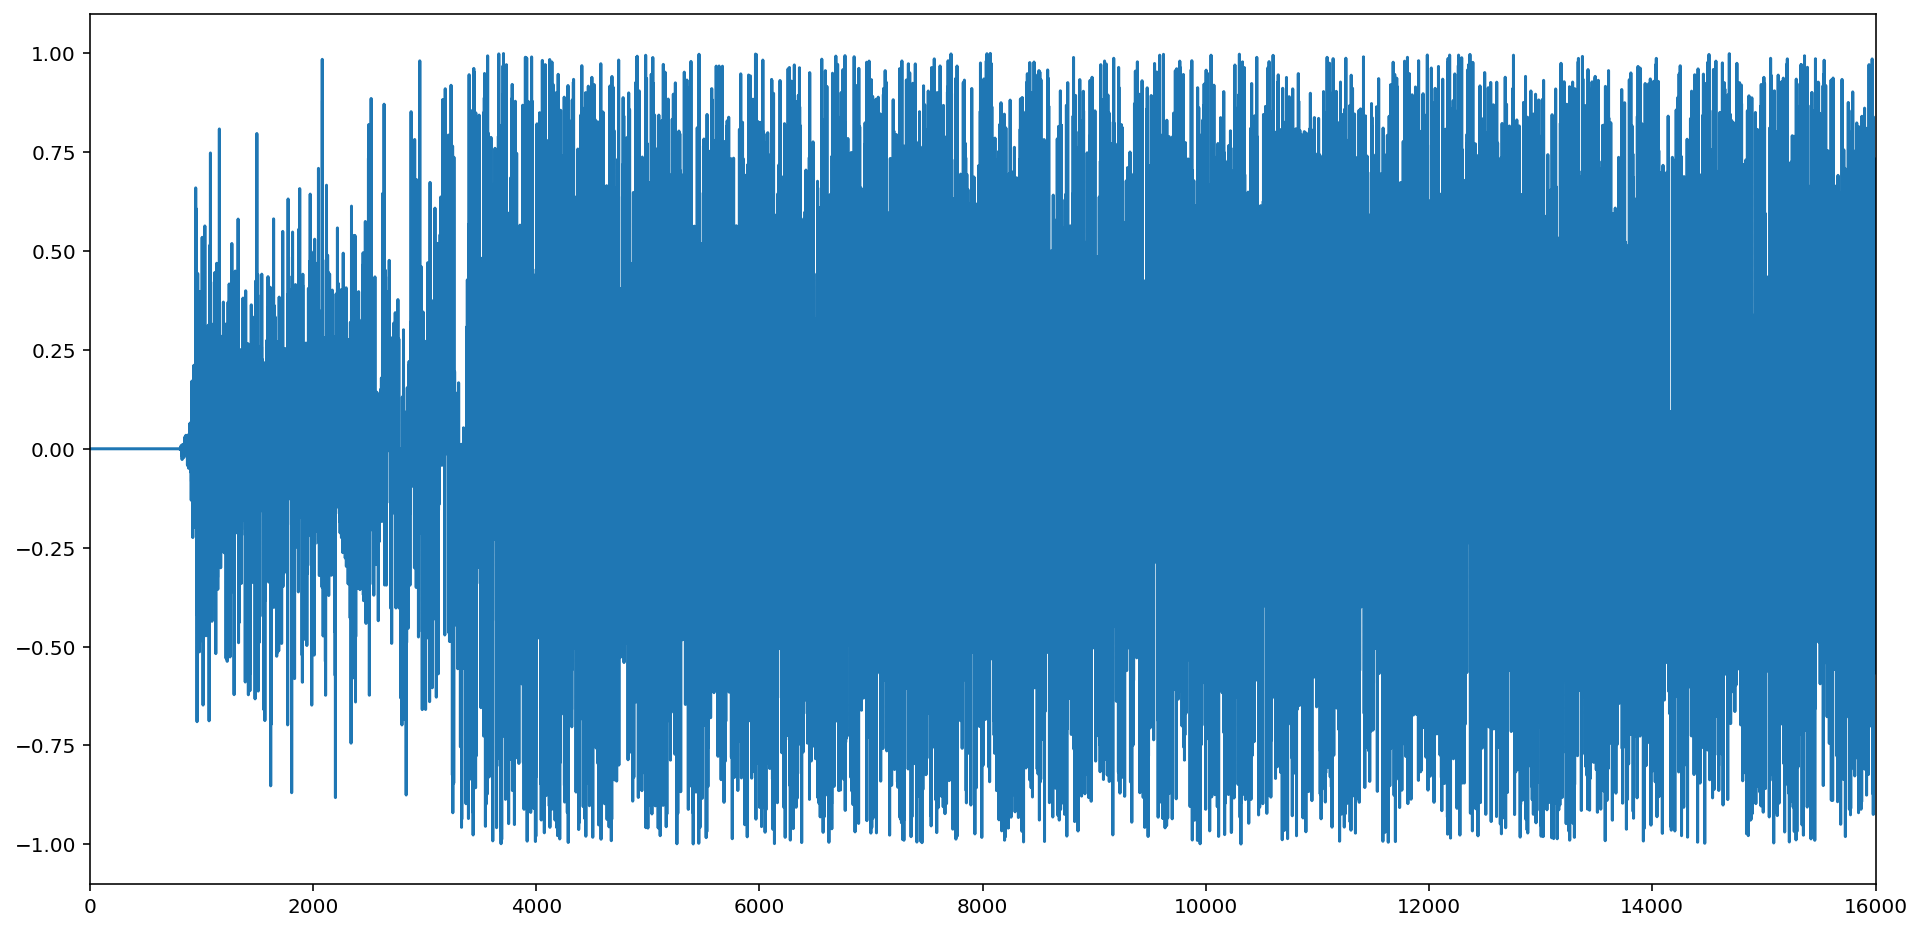

音声出力


In [4]:
#@title 音声データの表示
#@markdown - モノラルは1,ステレオは2
#@markdown - Sample width: サンプルサイズ
#@markdown - Frame Rate: フレームレート, 16khz
#@markdown - Frame num: フレーム数
#@markdown - Params: 録音パラメータ
#@markdown - Total time: 録音時間


def convert_audio_for_model(user_file, output_file='converted_audio_file.wav'):
  audio = AudioSegment.from_file(user_file)
  audio = audio.set_frame_rate(16000).set_channels(1)
  audio.export(output_file, format="wav")
  return output_file

# ファイルを読み出し
wavf = convert_audio_for_model(uploaded_file_name)
wr = wave.open(wavf, 'r')

# waveファイルが持つ性質を取得
ch = wr.getnchannels()
width = wr.getsampwidth()
fr = wr.getframerate()
fn = wr.getnframes()

print("音声波形の表示")
print("Channel: ", ch)
print("Sample width: ", width)
print("Frame Rate: ", fr)
print("Frame num: ", fn)
print("Params: ", wr.getparams())
print("Total time: ", 1.0 * fn / fr)

# waveの実データを取得し、数値化
data = wr.readframes(wr.getnframes())
wr.close()
X = (np.frombuffer(data, dtype="int16") / 32767.0)[0:fr]

import matplotlib.pyplot as plt 
plt.figure(figsize=(16,8))
plt.plot(X)
plt.xlim([0,np.size(X)])
plt.show()

#音声出力
print("音声出力")
IPython.display.Audio(wavf)


FFTの表示


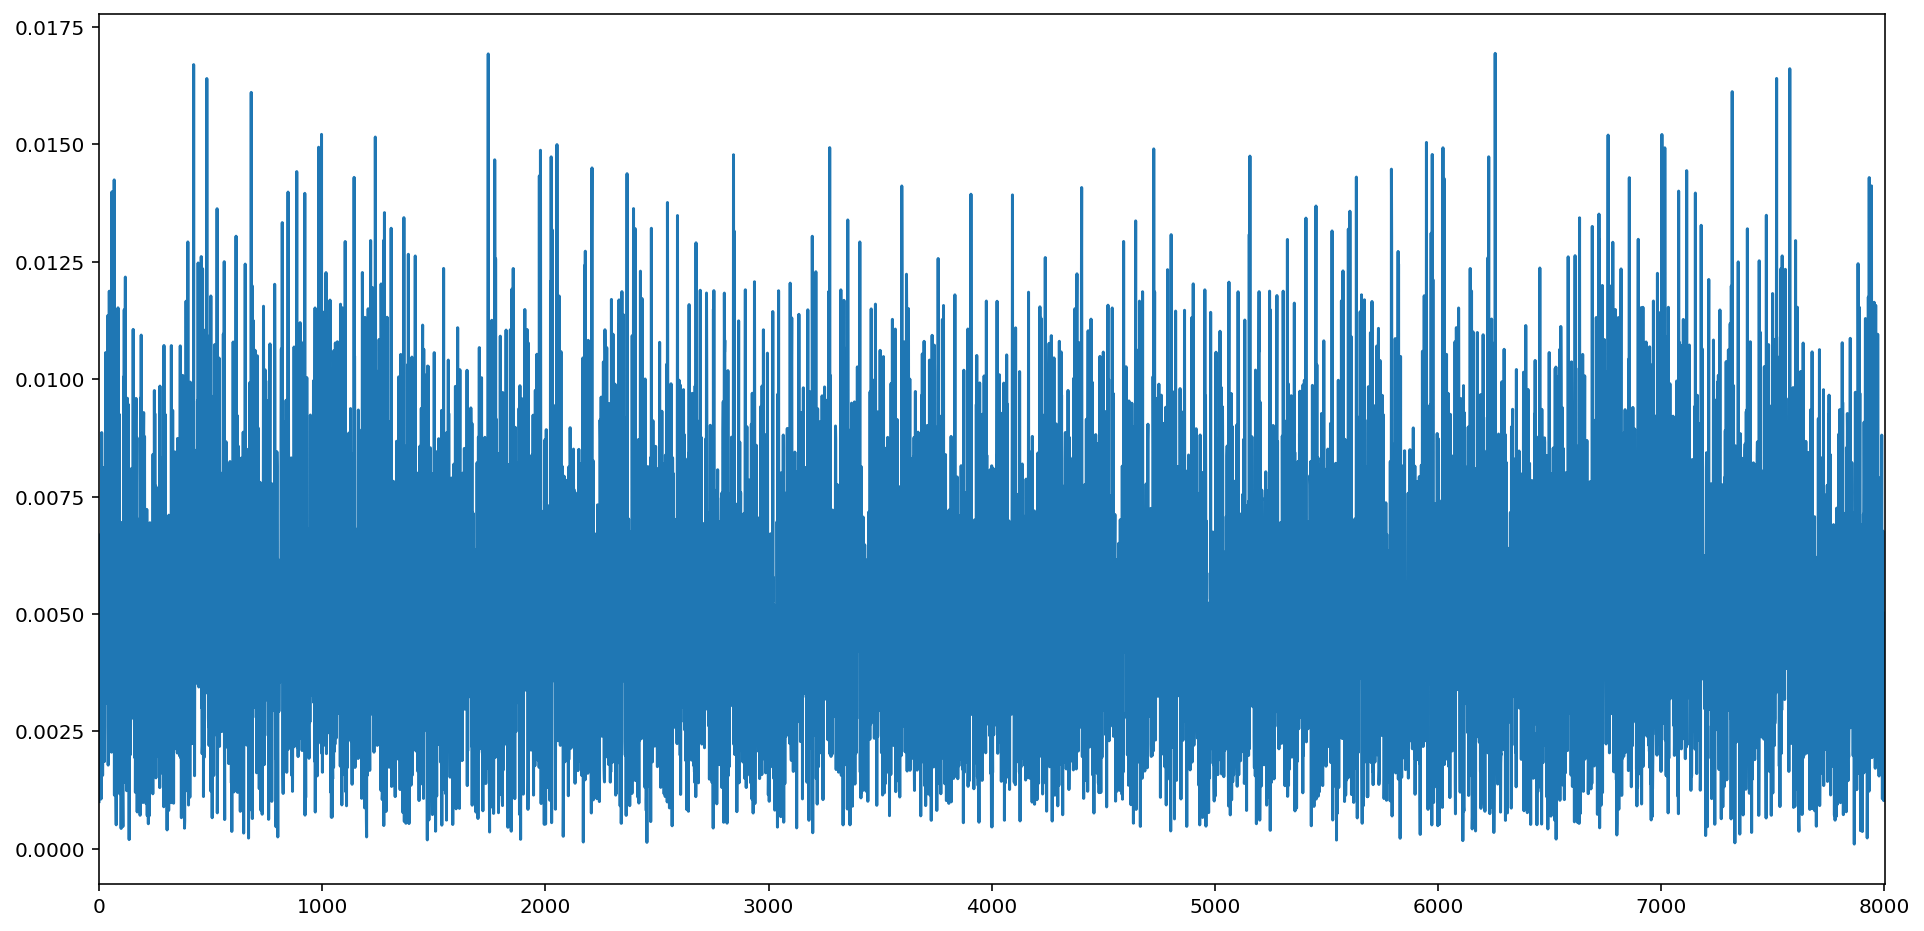

In [6]:
#@title FFTの表示
#@markdown - フーリエ変換はおまけなので、スルーしてください

print("FFTの表示")
fs = wr.getframerate()
s = (np.frombuffer(data, dtype="int16") / 32767.0)[0:fs]

F = np.fft.fft(s)
F_abs = np.abs(F)
F_a = F_abs / fs * 2
F_a[0] = F_abs[0] / fs
plt.figure(figsize=(16,8))
plt.plot(F_a[:int(fs/2)+1])
plt.xlim([0,np.size(F_a[:int(fs/2)+1])])
plt.show()

# **音声認識**

In [6]:
#@title 音声認識
#@markdown - 録音したデータを音声認識する

def convert_audio_for_model(user_file, output_file='converted_audio_file.wav'):
  audio = AudioSegment.from_file(user_file)
  audio = audio.set_frame_rate(16000).set_channels(1)
  audio.export(output_file, format="wav")
  return output_file

r = speech_recognition.Recognizer()

wav_file = convert_audio_for_model(uploaded_file_name)
print(wav_file, end=" -> ")
with speech_recognition.AudioFile(wav_file) as source:
  audio = r.record(source)
print(r.recognize_google(audio, language='ja-JP'))

converted_audio_file.wav -> 新前橋で会いましょう
